# Обзор базовых подходов к решению задачи Uplift Моделирования

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Содержание

* [Введение](#Введение)
* [1. Подходы с одной моделью](#1.-Подходы-с-одной-моделью)
    * [1.1 Одна модель](#1.1-Одна-модель-с-признаком-коммуникации)
    * [1.2 Трансформация классов](#1.2-Трансформация-классов)
* [2. Подходы с двумя моделями](#2.-Подходы-с-двумя-моделями)
    * [2.1 Две независимые модели](#2.1-Две-независимые-модели)
    * [2.2 Две зависимые модели](#2.3-Две-зависимые-модели)
* [Заключение](#Заключение)


https://www.uplift-modeling.com/en/latest/install.html

https://causalml.readthedocs.io/en/latest/installation.html

In [ ]:
import sys
!{sys.executable} -m pip install catboost causalml scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstal

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklift.datasets import fetch_x5
# from sklift.metrics import uplift_at_k
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
random_state = 47
k = 0.1

In [ ]:
def uplift_at_k(uplift_scores, y_true, treatment, k):
    n_top = int(len(uplift_scores) * k)
    indices = np.argsort(-uplift_scores)[:n_top]
    treat_top = treatment.iloc[indices]
    y_top = y_true.iloc[indices]
    return y_top[treat_top == 1].mean() - y_top[treat_top == 0].mean()

In [ ]:
df_clients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/fetch_x5_clients.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/fetch_x5_train.csv')

# df_clients содержит данные для обучения и теста, мы оставим только для обучения
# это необходимо, потому что будем замерять качество, а на тестовом семпле таргет  не дан
df_clients = df_clients[df_clients['client_id'].isin(df_train['client_id'])]
print(df_clients.shape, df_train.shape)

(200039, 5) (200039, 3)


In [ ]:
df_clients.head(2)

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F


In [ ]:
df_train.head(2)

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1


In [ ]:
print(f"Dataset features shape: {df_clients.shape}")
print(f"Dataset train shape: {df_train.shape}")
print(f"Dataset target mean: {df_train.target.mean()}")
print(f"Dataset treatment mean: {df_train.treatment_flg.mean()}")

Dataset features shape: (200039, 5)
Dataset train shape: (200039, 3)
Dataset target mean: 0.6198891216212838
Dataset treatment mean: 0.4998075375301816


In [ ]:
df_clients = df_clients.set_index('client_id')
df_train = df_train.set_index('client_id')

In [ ]:
cat_features = ['gender']

# df_clients[cat_features] = df_clients[cat_features].astype('category')

gender_encoder = LabelEncoder()
df_clients['gender_encoded'] = gender_encoder.fit_transform(df_clients['gender'])

In [ ]:
# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (pd.to_datetime(df_features['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features.head(2)

,age,gender,gender_encoded,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,,
000012768d,45,U,2,1501947648,1.515094e+09,13146559.0
000036f903,72,F,0,1491832463,1.492951e+09,1118613.0


In [ ]:
# отделяем 30% - пятую часть всего - на тестовую выборку
train, test = train_test_split(df_features, test_size=0.3, random_state=random_state)

indices_train = train.index.tolist()
indices_test = test.index.tolist()

X_train = df_features.loc[indices_train, :].drop(columns=['gender'])
y_train = df_train.loc[indices_train, 'target']
treat_train = df_train.loc[indices_train, 'treatment_flg']

X_test = df_features.loc[indices_test, :].drop(columns=['gender'])
y_test = df_train.loc[indices_test, 'target']
treat_test =  df_train.loc[indices_test, 'treatment_flg']

targets = [y_train, y_test]
treatmnets = [treat_train, treat_test]
names = ['train:',  'test:']

print('Баланс таргета на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

print('\nБаланс воздействия на разбиениях:\n')
i = 0
for treatmnet in treatmnets:
    pc = treatmnet.mean()
    print(names[i], pc)
    i += 1

Баланс таргета на разбиениях:

train: 0.6201018375027674
test: 0.6193927881090449

Баланс воздействия на разбиениях:

train: 0.49973933598520287
test: 0.4999666733320003


In [ ]:
X_test.shape

(60012, 5)

In [ ]:
models_results = {
    'approach': [],
    f'train_uplift@{k*100}%': [],
    f'test_uplift@{k*100}%': []
}

# 1. Подходы с одной моделью


## 1.1 Трансформация классов

В CausalML отсутствует прямая реализация ClassTransformation. Для реализации трансформации классов в CausalML можно реализовать подход вручную.

Напишем фунцию:
- Если объект в экспериментальной группе (treatment = 1), используем целевое значение как есть (y).
- Если объект в контрольной группе (treatment = 0), используем обратное значение (1 - y).

In [ ]:
def transform_classes(y, treatment):
    return np.where(treatment == 1, y, 1 - y)

In [ ]:
y_train_transformed = transform_classes(y_train, treat_train)
y_test_transformed = transform_classes(y_test, treat_test)

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)
catboost_model.fit(X_train, y_train_transformed)

uplift_train_CB = catboost_model.predict_proba(X_train)[:, 1] - catboost_model.predict_proba(X_train)[:, 0]
uplift_test_CB = catboost_model.predict_proba(X_test)[:, 1] - catboost_model.predict_proba(X_test)[:, 0]

In [ ]:
uplift_train_CB[:5]

array([0.01986238, 0.02304686, 0.08483507, 0.01627675, 0.06188252])

In [ ]:
# Распределение uplift
def plot_uplift_distribution(uplift_train, uplift_test, bins=30):
    plt.hist(uplift_train, bins=bins, alpha=0.5, label='Uplift Train', color='blue', edgecolor='black')
    plt.hist(uplift_test, bins=bins, alpha=0.5, label='Uplift Test', color='orange', edgecolor='black')
    plt.title("Distribution of Uplift Scores")
    plt.xlabel("Uplift Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

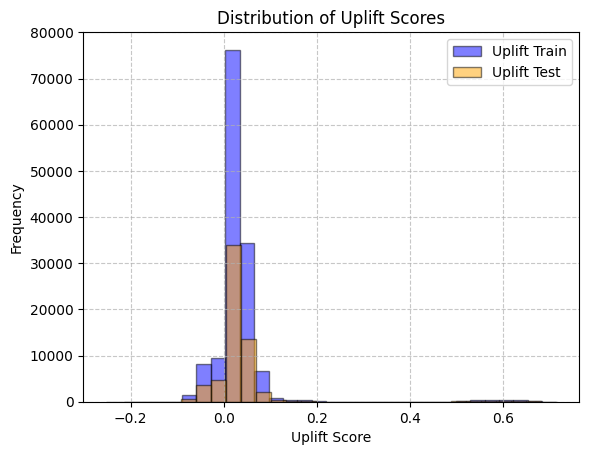

In [ ]:
plot_uplift_distribution(uplift_train_CB, uplift_test_CB)

In [ ]:
# from causalml.inference.visualize import plot

Нам нужен график!

1. Данные сортируются по оценке uplift, затем делятся на n_bins равных частей.
2. В каждом перцентиле вычисляется разница средних значений целевой переменной (y) между группами лечения и контроля.
3. На оси X – процентили, на оси Y – uplift.

In [ ]:
def plot_uplift_by_percentile(uplift, y_true, treatment, n_bins=10, title="Uplift by Percentile"):
    """
    Построение графика uplift по процентилям с добавлением средних значений целевой переменной
    для групп лечения и контроля.

    Parameters:
    - uplift: массив оценок uplift.
    - y_true: целевые значения.
    - treatment: индикатор группы лечения.
    - n_bins: количество процентилей.
    - title: заголовок графика.

    Returns:
    - results_df: DataFrame с результатами анализа uplift.
    """
    data = pd.DataFrame({'uplift': uplift, 'y': y_true, 'treatment': treatment})
    data = data.sort_values('uplift', ascending=False).reset_index(drop=True)

    bin_size = len(data) // n_bins
    results = []

    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else len(data)
        bin_data = data.iloc[start:end]

        treat_mean = bin_data.loc[bin_data['treatment'] == 1, 'y'].mean()
        control_mean = bin_data.loc[bin_data['treatment'] == 0, 'y'].mean()
        uplift_value = treat_mean - control_mean
        n_treatment = bin_data.loc[bin_data['treatment'] == 1].shape[0]
        n_control = bin_data.loc[bin_data['treatment'] == 0].shape[0]

        results.append({
            'percentile': i + 1,
            'uplift': uplift_value,
            'treat_mean': treat_mean,
            'control_mean': control_mean,
            'n_treatment': n_treatment,
            'n_control': n_control
        })

    results_df = pd.DataFrame(results)

    plt.plot(results_df['percentile'], results_df['uplift'], marker='o', linestyle='-', label='Uplift')
    plt.plot(results_df['percentile'], results_df['treat_mean'], marker='o', linestyle='--', label='Treatment Mean')
    plt.plot(results_df['percentile'], results_df['control_mean'], marker='o', linestyle='--', label='Control Mean')
    plt.title(title)
    plt.xlabel("Percentile")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, n_bins + 1))
    plt.show()

    return results_df


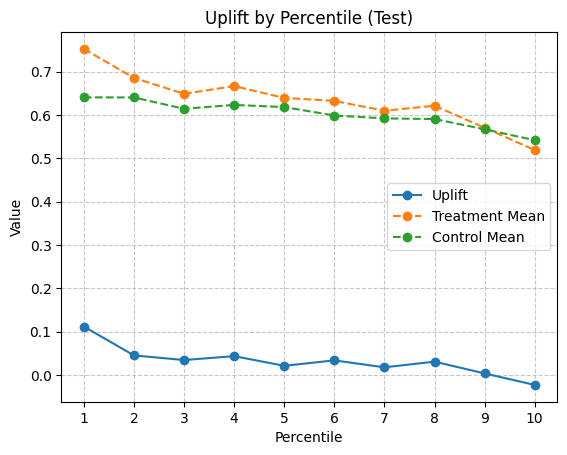

In [ ]:
res = plot_uplift_by_percentile(uplift_test_CB, y_test, treat_test, n_bins=10, title="Uplift by Percentile (Test)")

In [ ]:
train_uplift_k = uplift_at_k(uplift_train_CB, y_train, treat_train, k)
test_uplift_k = uplift_at_k(uplift_test_CB, y_test, treat_test, k)

models_results['approach'].append('ClassTransformation')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [ ]:
pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.149799,0.11176


## 1.2 Одна модель с признаком коммуникации

Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

In [ ]:
from causalml.inference.meta import BaseSClassifier

In [ ]:
s_learner = BaseSClassifier(
    learner=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    )
)

s_learner.fit(X=X_train.values, treatment=treat_train.values, y=y_train.values)

uplift_train_S = s_learner.predict(X=X_train.values.copy())
uplift_test_S = s_learner.predict(X=X_test.values.copy())

In [ ]:
uplift_train_S[:5]

array([[0.01530043],
       [0.02510291],
       [0.06313609],
       [0.02109956],
       [0.03555644]])

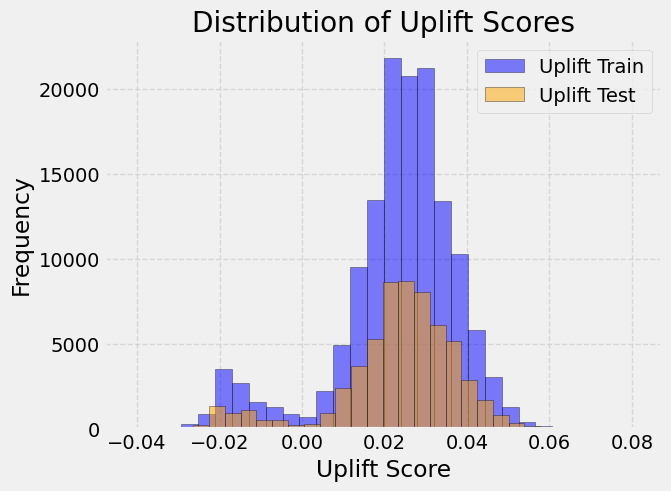

In [ ]:
plot_uplift_distribution(uplift_train_S, uplift_test_S)

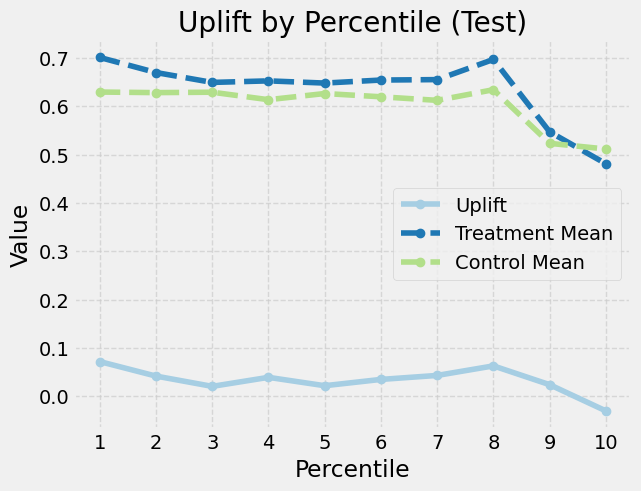

In [ ]:
res_S = plot_uplift_by_percentile(uplift_test_S.flatten(), y_test, treat_test, n_bins=10, title="Uplift by Percentile (Test)")

In [ ]:
train_uplift_k = uplift_at_k(uplift_train_S.flatten(), y_train, treat_train, k)
test_uplift_k = uplift_at_k(uplift_test_S.flatten(), y_test, treat_test, k)

models_results['approach'].append('S-Learner')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(train_uplift_k)

In [ ]:
pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.149799,0.11176
1,S-Learner,0.075230,0.07523


## 2. Подходы с двумя моделями

### 2.1 Две независимые модели

In [ ]:
from causalml.inference.meta import BaseTClassifier

In [ ]:
t_learner = BaseTClassifier(
    learner=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    )
)

t_learner.fit(X=X_train.values, treatment=treat_train.values, y=y_train.values)

uplift_train_T = t_learner.predict(X=X_train.values.copy())
uplift_test_T = t_learner.predict(X=X_test.values.copy())

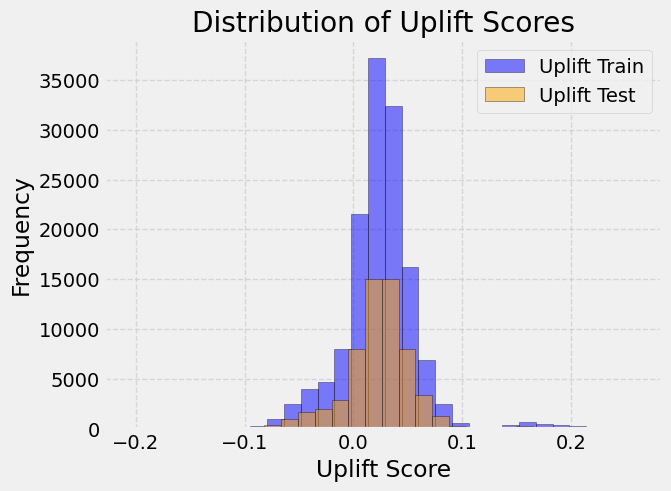

In [ ]:
plot_uplift_distribution(uplift_train_T, uplift_test_T)

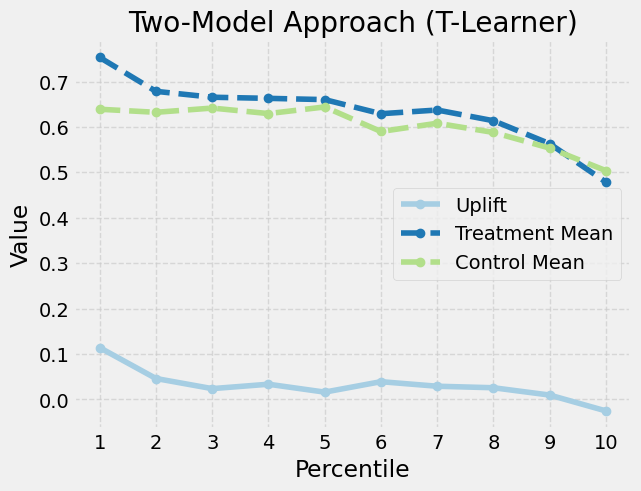

In [ ]:
res_T = plot_uplift_by_percentile(uplift_test_T.flatten(), y_test, treat_test, n_bins=10, title='Two-Model Approach (T-Learner)')

In [ ]:
train_uplift_k = uplift_at_k(uplift_train_T.flatten(), y_train, treat_train, k)
test_uplift_k = uplift_at_k(uplift_test_T.flatten(), y_test, treat_test, k)

models_results['approach'].append('Two-Model Approach (T-Learner)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [ ]:
pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.149799,0.111760
1,S-Learner,0.075230,0.075230
2,Two-Model Approach (T-Learner),0.146412,0.114067


### 2.2 Две зависимые модели

In [ ]:
from sklift.models import TwoModels

In [ ]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    ),
    estimator_ctrl=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    ),
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={
                'early_stopping_rounds': 10,
                'verbose': False #10
            },
    estimator_ctrl_fit_params={
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_tm_ctrl_train = tm_ctrl.predict(X_train)
uplift_tm_ctrl_test = tm_ctrl.predict(X_test)

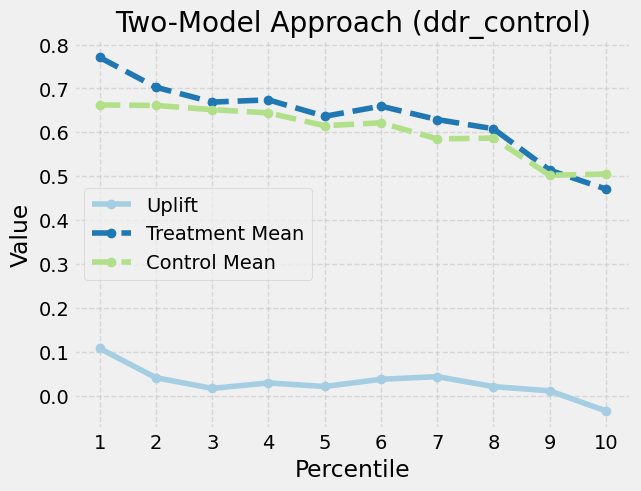

In [ ]:
res_ddr = plot_uplift_by_percentile(uplift_tm_ctrl_test, y_test, treat_test, n_bins=10, title='Two-Model Approach (ddr_control)')

In [ ]:
train_uplift_k = uplift_at_k(uplift_tm_ctrl_train, y_train, treat_train, k)
test_uplift_k = uplift_at_k(uplift_tm_ctrl_test, y_test, treat_test, k)

models_results['approach'].append('Two-Model Approach (ddr_control)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [ ]:
pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.149799,0.111760
1,S-Learner,0.075230,0.075230
2,Two-Model Approach (T-Learner),0.146412,0.114067
3,Two-Model Approach (ddr_control),0.121663,0.108137


Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

In [ ]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    ),
    estimator_ctrl=CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    ),
    method='ddr_treatment'
)

tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={
                'early_stopping_rounds': 10,
                'verbose': False #10
            },
    estimator_ctrl_fit_params={
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_tm_trmnt_train = tm_trmnt.predict(X_train)
uplift_tm_trmnt_test = tm_trmnt.predict(X_test)

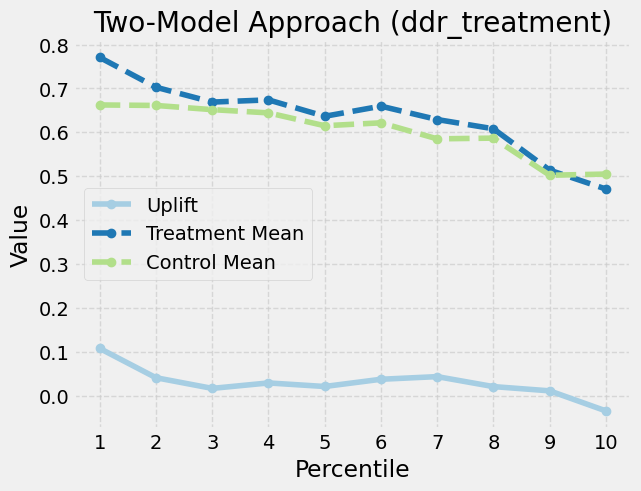

In [ ]:
res_ddr_treat = plot_uplift_by_percentile(uplift_tm_ctrl_test, y_test, treat_test, n_bins=10, title='Two-Model Approach (ddr_treatment)')

In [ ]:
train_uplift_k = uplift_at_k(uplift_tm_trmnt_train, y_train, treat_train, k)
test_uplift_k = uplift_at_k(uplift_tm_trmnt_test, y_test, treat_test, k)

models_results['approach'].append('Two-Model Approach (ddr_treatment)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.149799,0.111760
1,S-Learner,0.075230,0.075230
2,Two-Model Approach (T-Learner),0.146412,0.114067
3,Two-Model Approach (ddr_control),0.121663,0.108137
4,Two-Model Approach (ddr_treatment),0.101789,0.076922


## Метрики


In [ ]:
pd.DataFrame(data=models_results).sort_values(f'test_uplift@{k*100}%', ascending=False)

,approach,train_uplift@10.0%,test_uplift@10.0%
2,Two-Model Approach (T-Learner),0.146412,0.114067
0,ClassTransformation,0.149799,0.111760
3,Two-Model Approach (ddr_control),0.121663,0.108137
4,Two-Model Approach (ddr_treatment),0.101789,0.076922
1,S-Learner,0.075230,0.075230


In [ ]:
res_T

,percentile,uplift,treat_mean,control_mean,n_treatment,n_control
0,1,0.114067,0.753153,0.639086,3330,2671
1,2,0.046147,0.678524,0.632378,3036,2965
2,3,0.023853,0.665550,0.641697,2984,3017
3,4,0.033535,0.663091,0.629556,2983,3018
4,5,0.016169,0.660334,0.644166,3053,2948
5,6,0.039132,0.629236,0.590104,3010,2991
6,7,0.029117,0.637415,0.608298,2940,3061
7,8,0.025798,0.613818,0.588020,2996,3005
8,9,0.009688,0.563230,0.553543,2910,3091
9,10,-0.025218,0.478639,0.503857,2762,3241
